# Import Necessary Libraries


In [188]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set_palette('inferno')

%matplotlib inline

In [189]:
gt = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1',low_memory=False)


In [190]:
gt.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


The database contains over 180,000 cases of terrorist incidents, and we can verify that using shape of the loaded dataframe. Also, we see that there are 135 columns.

In [191]:
gt.shape

(181691, 135)

In [192]:
gt.dtypes #data is a mix ofof objects, floats and integers.

eventid                 int64
iyear                   int64
imonth                  int64
iday                    int64
approxdate             object
extended                int64
resolution             object
country                 int64
country_txt            object
region                  int64
region_txt             object
provstate              object
city                   object
latitude              float64
longitude             float64
specificity           float64
vicinity                int64
location               object
summary                object
crit1                   int64
crit2                   int64
crit3                   int64
doubtterr             float64
alternative           float64
alternative_txt        object
multiple              float64
success                 int64
suicide                 int64
attacktype1             int64
attacktype1_txt        object
                       ...   
propextent            float64
propextent_txt         object
propvalue 

In [193]:
#examine null values

nulls = gt.isnull().sum().sort_values(ascending=False)
nulls.head()

gsubname3           181671
weapsubtype4_txt    181621
weapsubtype4        181621
weaptype4           181618
weaptype4_txt       181618
dtype: int64

In [194]:
#Lets convert the count of null values for the columns into percentages to analyse.

row_count = gt.shape[0]
nulls_percentage = 100 * nulls / row_count
nulls_percentage.head()

gsubname3           99.988992
weapsubtype4_txt    99.961473
weapsubtype4        99.961473
weaptype4           99.959822
weaptype4_txt       99.959822
dtype: float64

In [195]:
#To help with analysis, lets bin them into few groups.
#I had noticed that some columns didn't have any null values so I have put in the No null pr 0% bin.
#Otherwise they will be binned into 4 quartiles

bins = (-1, 0, 25, 50, 75, 100)
labels = ['0%','1-25 %','25-50 %','50-75 %','75-100 %']

nulls_percentage_grouped = pd.cut(nulls_percentage, bins, labels=labels)
nulls_percentage_grouped.head()

gsubname3           75-100 %
weapsubtype4_txt    75-100 %
weapsubtype4        75-100 %
weaptype4           75-100 %
weaptype4_txt       75-100 %
dtype: category
Categories (5, object): [0% < 1-25 % < 25-50 % < 50-75 % < 75-100 %]

In [196]:
#31 columns have no null values 
#this is out of 135 columns. 
#Quite many columns 70 of them, have more than 75% null values.


nulls_percentage_grouped_counts = nulls_percentage_grouped.value_counts()
nulls_percentage_grouped_counts.sort_index()

0%          29
1-25 %      19
25-50 %     10
50-75 %      7
75-100 %    70
dtype: int64

Text(0,0.5,'Number of Columns')

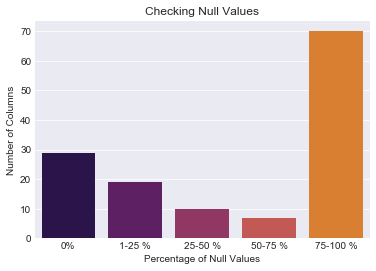

In [197]:
sns.barplot(nulls_percentage_grouped_counts.index,nulls_percentage_grouped_counts.values)
plt.title('Checking Null Values')
plt.xlabel('Percentage of Null Values')
plt.ylabel('Number of Columns')

In [198]:
#lets examine column values to get a sense of our data

gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


In [199]:
#Integer Columns
#I had also gone through the column descriptions from the Codebook 
#it can be downloaded from GTD database. It contains detailed descriptions of columns and their values.
#Begining with integer columns 
#I had tried using 'iyear', 'country' and 'weaptype1' from these columns to build a model. 
#The idea was - using the year in which the incident occured,
#along with the country, and weapon type and attack type used, can we predict which group may have been responsible.

#For this, I had used KNN (K Nearest Neighbors). 
#It did seem to give good predictions. 
#But when I tried to encode the categorical columms like year, country, region etc,
#the number of columns exploded, and KNN likely suffered from Curse of Dimensionality.
#Running KNN became a drag. KNN worked fine till around 10k rows, but near around 100k rows, it struggled.

In [200]:
cols_int = gt.select_dtypes(include=['int64']).columns
cols_int

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'region',
       'vicinity', 'crit1', 'crit2', 'crit3', 'success', 'suicide',
       'attacktype1', 'targtype1', 'individual', 'weaptype1', 'property',
       'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

In [201]:
#Float Columns


cols_float = gt.select_dtypes(include=['float64']).columns
cols_float

Index(['latitude', 'longitude', 'specificity', 'doubtterr', 'alternative',
       'multiple', 'attacktype2', 'attacktype3', 'targsubtype1', 'natlty1',
       'targtype2', 'targsubtype2', 'natlty2', 'targtype3', 'targsubtype3',
       'natlty3', 'guncertain1', 'guncertain2', 'guncertain3', 'nperps',
       'nperpcap', 'claimed', 'claimmode', 'claim2', 'claimmode2', 'claim3',
       'claimmode3', 'compclaim', 'weapsubtype1', 'weaptype2', 'weapsubtype2',
       'weaptype3', 'weapsubtype3', 'weaptype4', 'weapsubtype4', 'nkill',
       'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'propextent',
       'propvalue', 'ishostkid', 'nhostkid', 'nhostkidus', 'nhours', 'ndays',
       'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus',
       'hostkidoutcome', 'nreleased'],
      dtype='object')

In [202]:
gt[cols_float].head(3)

,latitude,longitude,specificity,doubtterr,alternative,multiple,attacktype2,attacktype3,targsubtype1,natlty1,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased
0,18.456792,-69.951164,1.0,0.0,NaN,0.0,NaN,NaN,68.0,58.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,19.371887,-99.086624,1.0,0.0,NaN,0.0,NaN,NaN,45.0,21.0,...,0.0,NaN,NaN,1.0,800000.0,NaN,NaN,NaN,NaN,NaN
2,15.478598,120.599741,4.0,0.0,NaN,0.0,NaN,NaN,54.0,217.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
#Texts Columns
#Lastly, texts columns.

#From these columns,
#I had tried using 'country_txt', 'region_txt', 'attacktype1_txt', 'weaptype1_txt' etc. 

#'gname' is our Target Variable
#gname is short for terrorist group name

cols_object = gt.select_dtypes(include=['object']).columns
cols_object

Index(['approxdate', 'resolution', 'country_txt', 'region_txt', 'provstate',
       'city', 'location', 'summary', 'alternative_txt', 'attacktype1_txt',
       'attacktype2_txt', 'attacktype3_txt', 'targtype1_txt',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1_txt', 'targtype2_txt',
       'targsubtype2_txt', 'corp2', 'target2', 'natlty2_txt', 'targtype3_txt',
       'targsubtype3_txt', 'corp3', 'target3', 'natlty3_txt', 'gname',
       'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive',
       'claimmode_txt', 'claimmode2_txt', 'claimmode3_txt', 'weaptype1_txt',
       'weapsubtype1_txt', 'weaptype2_txt', 'weapsubtype2_txt',
       'weaptype3_txt', 'weapsubtype3_txt', 'weaptype4_txt',
       'weapsubtype4_txt', 'weapdetail', 'propextent_txt', 'propcomment',
       'divert', 'kidhijcountry', 'ransomnote', 'hostkidoutcome_txt',
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'related'],
      dtype='object')

In [204]:
gt[cols_object].head()

,approxdate,resolution,country_txt,region_txt,provstate,city,location,summary,alternative_txt,attacktype1_txt,...,divert,kidhijcountry,ransomnote,hostkidoutcome_txt,addnotes,scite1,scite2,scite3,dbsource,related
0,NaN,NaN,Dominican Republic,Central America & Caribbean,NaN,Santo Domingo,NaN,NaN,NaN,Assassination,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
1,NaN,NaN,Mexico,North America,Federal,Mexico city,NaN,NaN,NaN,Hostage Taking (Kidnapping),...,NaN,Mexico,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
2,NaN,NaN,Philippines,Southeast Asia,Tarlac,Unknown,NaN,NaN,NaN,Assassination,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
3,NaN,NaN,Greece,Western Europe,Attica,Athens,NaN,NaN,NaN,Bombing/Explosion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
4,NaN,NaN,Japan,East Asia,Fukouka,Fukouka,NaN,NaN,NaN,Facility/Infrastructure Attack,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN


In [205]:
#examining our target variable Gname

#check for null values

gt.gname.isnull().sum()  #no null values

0

In [206]:
#Group names are either Unknown or the names of the groups responsible for the incident are recorded.
#There are around 78,000 cases for which groups are unknown. Our aim will be to predict the values of Unknown 

grp_counts = gt.gname.value_counts()
grp_counts.head(10)

Unknown                                             82782
Taliban                                              7478
Islamic State of Iraq and the Levant (ISIL)          5613
Shining Path (SL)                                    4555
Farabundo Marti National Liberation Front (FMLN)     3351
Al-Shabaab                                           3288
New People's Army (NPA)                              2772
Irish Republican Army (IRA)                          2671
Revolutionary Armed Forces of Colombia (FARC)        2487
Boko Haram                                           2418
Name: gname, dtype: int64

In [207]:
# close to 100k groups are known. We have around 180k instances, thus majority of groups are known


grp_counts_known = grp_counts.loc[grp_counts.index != 'Unknown'].sum()
print('Group counts known: ' ,grp_counts_known)

grp_counts_unknown = grp_counts[0]
print('Group counts unknown: ' ,grp_counts_unknown)

Group counts known:  98909
Group counts unknown:  82782


Text(0,0.5,'Percentage of Attacks')

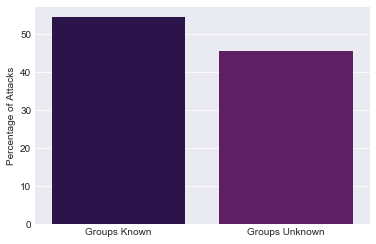

In [208]:
#visualize this breakdown

sns.barplot(['Groups Known','Groups Unknown'],100 * np.array([grp_counts_known, grp_counts_unknown]) / row_count)
plt.ylabel('Percentage of Attacks')

In [209]:
#Most Active Groups

#total of 3537 groups. We will remove one which is unknown


grp_counts.shape

(3537,)

In [210]:
#top 10 groups list
top10 = grp_counts[1:11]
top10

Taliban                                             7478
Islamic State of Iraq and the Levant (ISIL)         5613
Shining Path (SL)                                   4555
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          3288
New People's Army (NPA)                             2772
Irish Republican Army (IRA)                         2671
Revolutionary Armed Forces of Colombia (FARC)       2487
Boko Haram                                          2418
Kurdistan Workers' Party (PKK)                      2310
Name: gname, dtype: int64

Text(0.5,1,'10 Most Active Groups\n1970-2018')

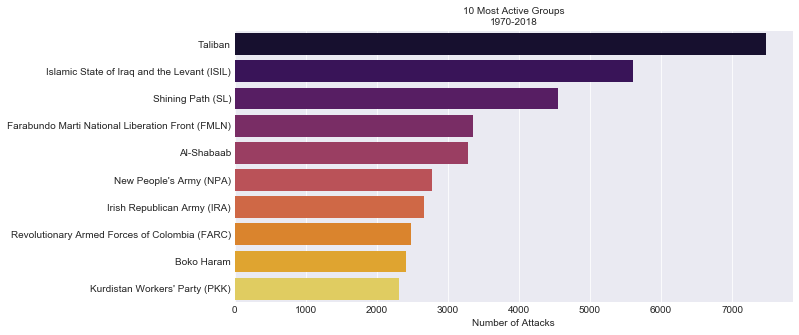

In [211]:
plt.subplots(figsize=(10, 5))
sns.barplot(top10.values, top10.index, palette='inferno')
plt.xlabel('Number of Attacks')
plt.title('10 Most Active Groups\n1970-2018', fontsize=10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text xticklabel objects>)

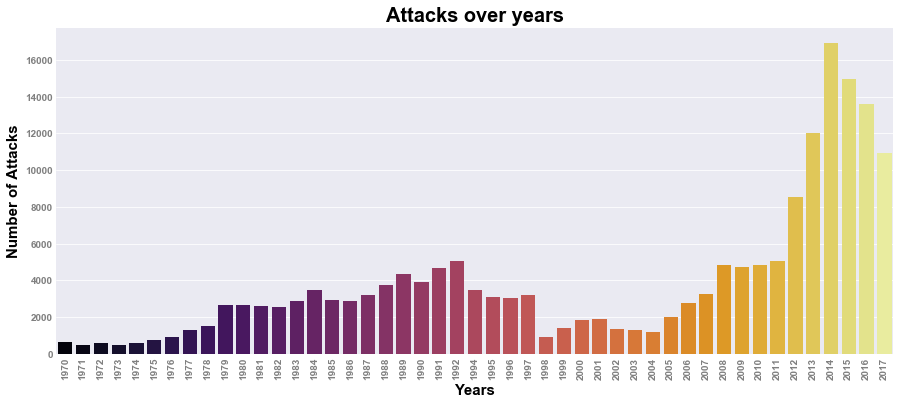

In [212]:
plt.figure(figsize=(15,6))
#plt.plot(years_in_database,attacks_per_year,,color='olive', linestyle ='-',marker='.',linewidth = '5')
sns.countplot('iyear',data=gt,palette='inferno')


plt.xlabel('Years',fontsize = 15,weight   = 'bold',color = 'black')
plt.ylabel('Number of Attacks',fontsize = 15,weight   = 'bold',color = 'black')

plt.title('Attacks over years',fontsize = 20,weight   = 'extra bold', color    = 'black')
plt.yticks(rotation = 0, weight   = 'bold', fontsize = 10, color   = 'grey')
plt.xticks(weight   = 'bold', fontsize = 10,color = 'grey',rotation=90)



Text(0.5,1,'10 Most Volatile Years\n1970-2018')

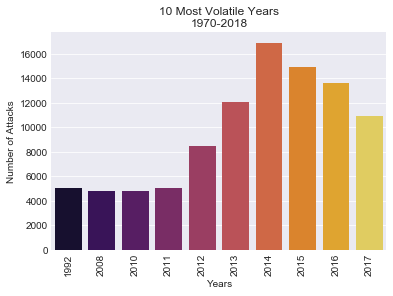

In [213]:
#top 10 years with highest terrorist activity
year_attacks = gt.iyear.value_counts()
top10_years = year_attacks.sort_values(ascending=False).head(10)

sns.barplot(top10_years.index, top10_years.values,palette='inferno')
plt.xticks(rotation=90)
plt.ylabel('Number of Attacks')
plt.xlabel('Years')
plt.title('10 Most Volatile Years\n1970-2018', fontsize=12)

Text(0.5,1,'Terrorist Attacks by Decades\n1970-2018')

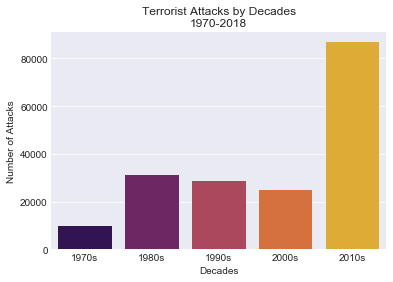

In [214]:
#bin years by decades
bins = (1969, 1979, 1989, 1999, 2009, 2018)
labels = ['1970s', '1980s', '1990s', '2000s', '2010s']

year_decades = pd.cut(gt.iyear, bins, labels=labels)

year_decades_attacks = year_decades.value_counts()


sns.barplot(year_decades_attacks.index, year_decades_attacks.values, palette='inferno')
plt.xlabel('Decades')
plt.ylabel('Number of Attacks')
plt.title('Terrorist Attacks by Decades\n1970-2018', fontsize=12)

#a huge surge in terrorist incidents in the last decade can be observed.

In [215]:
#lets look at the top countries affected by terrorism

country_attacks = gt.country_txt.value_counts()
top10_countries = country_attacks.head(10)
top10_countries

Iraq              24636
Pakistan          14368
Afghanistan       12731
India             11960
Colombia           8306
Philippines        6908
Peru               6096
El Salvador        5320
United Kingdom     5235
Turkey             4292
Name: country_txt, dtype: int64

Text(0.5,1,'10 Countries Most Affected by Terrorism\n1970-2018')

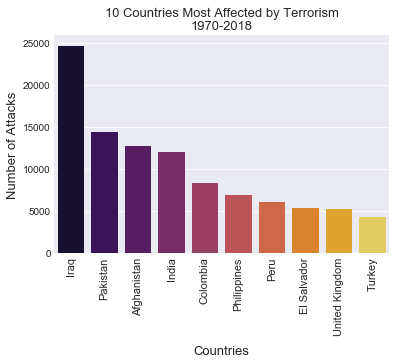

In [216]:
sns.barplot(top10_countries.index, top10_countries.values,palette='inferno')
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Countries', labelpad=10, fontsize=13)
plt.ylabel('Number of Attacks', fontsize=13)
plt.title('10 Countries Most Affected by Terrorism\n1970-2018', fontsize=13)

# Model building


In [217]:
gt.shape

#We have 180,000 rows and 135 columns to work with.

(181691, 135)

In [218]:
#Our target column will be gname.
#This is the terrorist group name.

#After experimenting with a few features
#I had tried with year, country, region, attack type used, weapon type used and not getting satisfactory result
#(I tried with KNN and Logistic Regression)

#The summary column(the description of the terrorist incident or attack) 
#is rich in information. It contains dates, years, months; and sometimes cities,
#towns and countries where the incident occurred. 
#It also contained other information that would be difficult to capture by numbers alone.

#It seemed to be a good predictor for idenitfing the groups.

#I created a dataframe called summary_gname that has only summary and gname columns

In [219]:
summary_gname = gt.loc[:, ['summary','gname']]
summary_gname.tail()

,summary,gname
181686,12/31/2017: Assailants opened fire on a Somali...,Al-Shabaab
181687,12/31/2017: Assailants launched mortars at the...,Muslim extremists
181688,12/31/2017: Assailants set fire to houses in K...,Bangsamoro Islamic Freedom Movement (BIFM)
181689,12/31/2017: Assailants threw a grenade at a Fo...,Unknown
181690,12/31/2017: An explosive device was discovered...,Unknown


In [220]:
#As we seen before, gname column has no null values. 
#But summary has some null values. Around 60,000 of them. 
#So from a total available of 180,000, if we let go of the 66,000 we will still have more than 100,000 to build our model.

#We will end up dropping more rows later because of the Unknown groups.

summary_gname.isnull().sum()

summary    66129
gname          0
dtype: int64

In [221]:
summary_gname.gname.value_counts().shape #total number of groups = 3537

(3537,)

In [222]:
#drop all null values of summary column so that we have good data to work with

summary_gname.dropna(inplace=True)
summary_gname.head()

,summary,gname
5,1/1/1970: Unknown African American assailants ...,Black Nationalists
7,1/2/1970: Unknown perpetrators detonated explo...,Unknown
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants


In [223]:
summary_gname.shape #this is how our data looks like now

(115562, 2)

In [224]:
#Separating Unknown and Known Groups
#Around 60,000 cases have Unknown groups. 
#These are ones we will be predicting the terrorist group

In [225]:
(summary_gname.gname == 'Unknown').sum()

59633

In [226]:
unknown_grps = summary_gname.loc[summary_gname.gname == 'Unknown'].copy()
unknown_grps.head()  #storing them separately

,summary,gname
7,1/2/1970: Unknown perpetrators detonated explo...,Unknown
40,1/31/1970: Unknown perpetrators bombed the Pol...,Unknown
43,2/2/1970: An incendiary device was discovered ...,Unknown
44,"2/3/1970: In a series of related attacks, an i...",Unknown
45,"2/3/1970: In a series of related attacks, an i...",Unknown


In [227]:
known_grps = summary_gname.loc[summary_gname.gname != 'Unknown'].copy()
known_grps.head()  #same process for the known groups

,summary,gname
5,1/1/1970: Unknown African American assailants ...,Black Nationalists
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants
13,1/9/1970: Unknown perpetrators set off a fireb...,Left-Wing Militants


In [228]:
known_grps.shape #slightly less than unknown groups

(55929, 2)

In [229]:
#examining a few Samples of Summary Column
#Looking at few samples of summary column. We can observe the information stored in this columns
#It has dates, group names, target names, countries, cities, property damages, devices used, casualties etc.

known_grps.iloc[58,0]

'2/23/1970: In a series of related attacks, unknown perpetrators bombed four separate power transmission poles in the Dakota City and Sioux City areas in Nebraska, United States.  There were no casualties and none of the dynamite blasts broke off any of the poles.   These attacks were one of many instances of violence in South Sioux City during the Iowa Beef Packers strike.'

In [230]:
known_grps.iloc[1098,0]

'03/19/1991: Members of the Liberation Tigers of Tamil Eelam (LTTE) attacked an army camp in Silavathurai, Sri Lanka.   The attack involved mortar bombs, small arms fire and grenades and it continued for three successive nights.  Five soldiers were killed.'

In [231]:
#top 10 active groups
grpCounts = known_grps.gname.value_counts()
grpCounts.head(10)

Taliban                                           7474
Islamic State of Iraq and the Levant (ISIL)       5613
Al-Shabaab                                        3288
Boko Haram                                        2418
Communist Party of India - Maoist (CPI-Maoist)    1878
New People's Army (NPA)                           1800
Maoists                                           1619
Tehrik-i-Taliban Pakistan (TTP)                   1351
Revolutionary Armed Forces of Colombia (FARC)     1331
Kurdistan Workers' Party (PKK)                    1285
Name: gname, dtype: int64

In [232]:
#We are left with around 1700 groups to work with.
#Of the total of around 3500 groups that were there in the original database, 
#some more than half had to be let go,this happened when we dropped summary column with null values.
#They don't have summary descriptions against the incidents attributed to them.

#To build a model using the group names dropped,
#we have to pick columns manually from the other 134 columns,
#which will be an exercise for another day

grpCounts.shape

(1686,)

In [233]:
#Binning Groups
#Lets encode the group names.

#6 being the most active & they have caused more than 500 incidents.
#1 is the least active group & they have been attributed to only one incident.

bins = (0, 1, 10, 50, 100, 500, 10000)
labels = [1, 2, 3, 4, 5, 6]

grpCuts = pd.cut(grpCounts, bins, labels=labels)
grpCuts.head()

Taliban                                           6
Islamic State of Iraq and the Levant (ISIL)       6
Al-Shabaab                                        6
Boko Haram                                        6
Communist Party of India - Maoist (CPI-Maoist)    6
Name: gname, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [234]:
#Group distribution.
#Dataframe below is a good depiction of the group distribution.
#18 groups were most active. 722 groups were involved reported in only one incident.



gt_grpCodes = pd.DataFrame({'Group Code':np.arange(1,7),
            'Number of Groups':grpCuts.value_counts().sort_index(),
            'Number of Attacks (Range)':['1', '2-10','10-50','50-100','100-500','500-10000']})
gt_grpCodes.set_index('Group Code', inplace=True)
gt_grpCodes

,Number of Groups,Number of Attacks (Range)
Group Code,,
1,722,1
2,641,2-10
3,211,10-50
4,48,50-100
5,46,100-500
6,18,500-10000


In [235]:
gt_grpCodes['Number of Groups'].sum()

1686

In [236]:
grp_dict = {}

for grp_Code in range(1,7):
    grp_dict[grp_Code]= grpCuts[grpCuts.values==grp_Code].index.tolist()

In [237]:
#taking a look
grp_dict[3][:10]

['Hutu extremists',
 'Niger Delta Avengers (NDA)',
 'Tawhid and Jihad',
 'Patriotic Resistance Front in Ituri (FRPI)',
 'Popular Resistance Committees',
 'Islamist extremists',
 'Oglaigh na hEireann',
 'Adan-Abyan Province of the Islamic State',
 'Albanian extremists',
 'Arakan Rohingya Salvation Army (ARSA)']

In [238]:
grp_dict[6][:10]

['Taliban',
 'Islamic State of Iraq and the Levant (ISIL)',
 'Al-Shabaab',
 'Boko Haram',
 'Communist Party of India - Maoist (CPI-Maoist)',
 "New People's Army (NPA)",
 'Maoists',
 'Tehrik-i-Taliban Pakistan (TTP)',
 'Revolutionary Armed Forces of Colombia (FARC)',
 "Kurdistan Workers' Party (PKK)"]

In [239]:
# next step is to Map Group Names
#Defining a function to map group names with their group codes.


def grpCodes(gname):
    for key,value in grp_dict.items():
        if gname in value:
            return key
        


In [240]:
known_grps['gname_code'] = known_grps.gname.map(lambda x:grpCodes(x))

known_grps.head()

,summary,gname,gname_code
5,1/1/1970: Unknown African American assailants ...,Black Nationalists,4
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang,2
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang,2
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants,5
13,1/9/1970: Unknown perpetrators set off a fireb...,Left-Wing Militants,5


In [241]:
# lets analyse Group Distributions

#Number of incidents attributed to the groups encoded. Groups 1 to 6.

#Group 6 caused an unproportionate high number of attacks. And they consist of just 18 groups.


gt_grpCodes['Total Number of attacks per group'] =known_grps.gname_code.value_counts().sort_index()

gt_grpCodes


,Number of Groups,Number of Attacks (Range),Total Number of attacks per group
Group Code,,,
1,722,1,722
2,641,2-10,2560
3,211,10-50,4916
4,48,50-100,3492
5,46,100-500,10522
6,18,500-10000,33717


In [242]:
#Features and Targets

#x is the independent variable summary column descriptions of the terrorist incident.

#y is the target variable terrorist groups responsible.


In [243]:
x = known_grps.summary
y = known_grps.gname_code

In [244]:
#Checking shape of feature and target. We will be working with around 56,000 features and targets.

x.shape,y.shape

((55929,), (55929,))

In [245]:
#Checking data type of x and y. 
#Scikit Learn models expect numpy arrays. 
#But because pandas is built on top of Numpy, pandas series is fine too.

type(x),type(y)

(pandas.core.series.Series, pandas.core.series.Series)

In [246]:
#70:30 split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [247]:
#peeking into our data splits
splits = [x_train, x_test, y_train, y_test]
for a in splits:
    print(a.shape)

(39150,)
(16779,)
(39150,)
(16779,)


In [248]:
#Vectorising Texts
#Initialise CountVectorizer. 
#This will be used to vectorise the summary texts, 
#which can then be used to feed into machine learning models.

In [249]:
vect = CountVectorizer()

In [250]:
vect.fit(x_train) #the vocabulary from the training samples here.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [251]:
#Converts the learned vocabulary into matrix. dtm is short for document term matrix.

x_train_dtm = vect.transform(x_train)
x_train_dtm

<39150x45015 sparse matrix of type '<class 'numpy.int64'>'
	with 1683814 stored elements in Compressed Sparse Row format>

In [252]:
#Transforming the test set.


In [253]:
x_test_dtm = vect.transform(x_test)
x_test_dtm

<16779x45015 sparse matrix of type '<class 'numpy.int64'>'
	with 709434 stored elements in Compressed Sparse Row format>

In [254]:
#Naive Bayes
#Intialising Naive Bayes.

In [255]:
nb = MultinomialNB()

In [256]:
nb.fit(x_train_dtm, y_train) #pass x_train_dtm

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [257]:
y_pred_nb = nb.predict(x_test_dtm)

In [258]:
metrics.accuracy_score(y_test, y_pred_nb)  #Naive Bayes gives accuracy score of around 85%.

0.8524941891650277

In [259]:
#Confusion Matrix - we get a 6 by 6 matrix for 6 groups. 
#The topmost left is for group 1 while bottom right corner is for group 6.

#Naive Bayes did pretty well with predicting groups from group 6
#but it struggled to find any predictions from group 1, perhaps because of less samples.

metrics.confusion_matrix(y_test, y_pred_nb)

array([[   0,   27,   72,   17,   69,   43],
       [   0,  152,  174,   48,  250,  161],
       [   0,    9,  875,   55,  287,  281],
       [   0,    5,   48,  627,  195,  131],
       [   0,    3,   51,   52, 2855,  274],
       [   0,   11,   79,   16,  117, 9795]])

In [260]:
#Below we get f1 score along with precision and recall.

#Notice how for group 6, it looks quite good, while for group 1 it is all 0. Overall f1 score is 83%.

print(metrics.classification_report(y_test, y_pred_nb))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       228
          2       0.73      0.19      0.31       785
          3       0.67      0.58      0.62      1507
          4       0.77      0.62      0.69      1006
          5       0.76      0.88      0.81      3235
          6       0.92      0.98      0.95     10018

avg / total       0.83      0.85      0.83     16779



In [261]:
#Logistic regression

lr = LogisticRegression()

In [262]:
lr.fit(x_train_dtm, y_train) #Fitting a model with Logistic Regression.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [263]:
y_pred_lr = lr.predict(x_test_dtm)

In [264]:
#We get accuracy score of 92%, much higher than Naive Bayes.

#So looks like the trade off is between speed and accuracy.

metrics.accuracy_score(y_test, y_pred_lr)

0.9290780141843972

In [265]:
#Confusion Matrix for Logistic Regression.

#Notice here that it did predict some group 1s, unlike with Naive Bayes. It did well with group 6 anyways.

metrics.confusion_matrix(y_test, y_pred_lr)

array([[  29,   73,   54,   10,   29,   33],
       [  18,  466,  124,   38,   83,   56],
       [  11,   57, 1202,   42,  108,   87],
       [   3,   13,   41,  879,   25,   45],
       [   3,   20,   56,   20, 3097,   39],
       [   1,   12,   35,   11,   43, 9916]])

In [266]:
#F1 score along with precision and recall for Logistic Regression.

#Here, interesting to note is precisiong and recall for group 1 is no longer 0 like with Naive Bayes.

print(metrics.classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          1       0.45      0.13      0.20       228
          2       0.73      0.59      0.65       785
          3       0.79      0.80      0.80      1507
          4       0.88      0.87      0.88      1006
          5       0.91      0.96      0.94      3235
          6       0.97      0.99      0.98     10018

avg / total       0.92      0.93      0.92     16779



In [267]:
#A Variation of KFold Cross Validation (4 fold CV)
#Now that we have tried once with both Naive Bayes and Logistic Regression, 
#lets try few runs of each and take their means so that the results we got above was not a one-time-lucky phenomenon.

#To achieve that lets define a function as below.

#The function will run for 4 iterations,
#and return accuracy scores and f1 scores for the 4 runs. We will use them to calculate means of the scores.

In [268]:
def mean_clf(x, y, clf):
    
    accuracyScores = []
    f1Scores = []
    
    for iter in range(4):    
        
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        vect = CountVectorizer()
        vect.fit(x_train)
        x_train_dtm = vect.transform(x_train)
        x_test_dtm = vect.transform(x_test)

        clf.fit(x_train_dtm, y_train)
        y_pred = clf.predict(x_test_dtm)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred, average='weighted')
        accuracyScores.append(accuracy)
        f1Scores.append(f1)
    
    return accuracyScores, f1Scores

In [269]:
#for naive bayes


nb = MultinomialNB()
accuracy_nb, f1_nb = mean_clf(x, y, nb)
print(accuracy_nb)
print(f1_nb)

[0.8581849388543231, 0.8534649216906244, 0.8586855467353215, 0.8568261460344704]
[0.8404619219819726, 0.8350451266548103, 0.8407946552327665, 0.8398419759330269]


In [270]:
#The results look consistent.

#Trying with Logistic Regression

In [271]:
lr = LogisticRegression()
accuracy_lr, f1_lr = mean_clf(x, y, lr)
print(accuracy_lr)
print(f1_lr)

[0.9350640062933562, 0.9314167203032253, 0.9311306586569406, 0.9324894514767933]
[0.9309512206670394, 0.9266000826159237, 0.9263570914832172, 0.9271856920016663]


In [272]:
#The results look consistent for Logistic Regression too.

#Lets build a dataframe to summarise

pd.DataFrame({'Accuracy Score':[np.array(accuracy_nb).mean(), np.array(accuracy_lr).mean()],
             'F1 Score': [np.array(f1_nb).mean(), np.array(f1_lr).mean()]},
             index=['Naive Bayes','Logistic Regression'])

,Accuracy Score,F1 Score
Naive Bayes,0.856790,0.839036
Logistic Regression,0.932525,0.927774


In [273]:
#Predicting Unknown Groups
#So we have worked with building 2 models - Naive Bayes and Logistic Regression, and evaluated them.

#Now let's see what the predictions for the Unknown groups come out to be.

#Before we predict, we should use the whole dataset to train again, else we end up throwing away useful data.

#Lets use CountVectorizer to vectorise x - this has the whole dataset. Not just training set.



In [274]:
vect = CountVectorizer()
vect.fit(x)
x_dtm = vect.transform(x)
unknown_grps_dtm = vect.transform(unknown_grps.summary)

In [275]:
nb = MultinomialNB()
nb.fit(x_dtm, y)
unknown_grps_pred_nb = nb.predict(unknown_grps_dtm)
print(unknown_grps_pred_nb)  #Predicting with Naive Bayes.

[4 4 4 ... 6 3 5]


In [276]:
lr = LogisticRegression()
lr.fit(x_dtm, y)
unknown_grps_pred_lr = lr.predict(unknown_grps_dtm)
print(unknown_grps_pred_lr)  #Logistic regression

[4 5 4 ... 6 3 5]


In [277]:
#distribution of predictions - NB

nb_pred = pd.Series(unknown_grps_pred_nb).value_counts().sort_index()
nb_pred

1        1
2      562
3     4889
4     1649
5    15286
6    37246
dtype: int64

In [278]:
#distribution of predictions - LR

lr_pred = pd.Series(unknown_grps_pred_lr).value_counts().sort_index()
lr_pred

1      806
2     3478
3     7438
4     2980
5    13430
6    31501
dtype: int64

In [280]:
#summarise the predictions of both models

gt_pred = pd.DataFrame({'Naive Bayes': nb_pred,
             'Logistic Regression': lr_pred,
             'Group Code': np.arange(1, 7)}).set_index('Group Code')
gt_pred = gt_pred[['Naive Bayes','Logistic Regression']]
gt_pred

,Naive Bayes,Logistic Regression
Group Code,,
1,1,806
2,562,3478
3,4889,7438
4,1649,2980
5,15286,13430
6,37246,31501
